# Hackathon : Classification + Weight/Yield Prediction

This notebook covers:
- Classification (SVM, KNN, Random Forest, BPNN) + baselines
- Regression (Linear, Random Forest Regressor, Gradient Boosting) + simple baselines
- 70:30 split, 5-fold CV
- Feature importance (built-in, permutation) + SHAP (if available)
- Generates a `submission.csv` for the unlabeled prediction file

## Files needed
- `Goat Classification dataset.csv`
- `Weight and Yield pprediction Data set.csv`
- `hackathon_prediction_features.csv` (provided by organizers)


#Imports

The bottom cell loads the core Python libraries for data handling (pandas/numpy), model building (scikit-learn), and plotting (matplotlib).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
print('Imports OK')


Imports OK


## Part A — Classification (Condition: Healthy (H) vs Parasitized (P))

This cell helps to upload the CSV files into Colab and reads the classification and regression datasets into dataframes. It also prints dataset shapes and shows the first few rows to confirm the files loaded correctly.

In [ ]:
from google.colab import files
uploaded = files.upload()

# Set filenames (edit if your names differ)
CLASSIFICATION_CSV = 'Goat Classification dataset.csv'
REGRESSION_CSV     = 'Weight and Yield pprediction Data set.csv'

# Load
df_cls = pd.read_csv(CLASSIFICATION_CSV)
df_reg = pd.read_csv(REGRESSION_CSV)

print('Classification shape:', df_cls.shape)
display(df_cls.head())
print('\nRegression shape:', df_reg.shape)
display(df_reg.head())

df = pd.read_csv('Goat Classification dataset.csv')
assert 'Condition' in df.columns, 'Expected a Condition column'

# Features / label
X = df.drop(columns=['Condition'])
y = df['Condition'].astype(str).str.strip().str.upper()

# One-hot encode categoricals (Species/Type)
X = pd.get_dummies(X, drop_first=True)

print('X shape:', X.shape)
print('Label distribution:\n', y.value_counts())
display(df.head())


Saving Weight and Yield pprediction Data set.csv to Weight and Yield pprediction Data set.csv
Saving Goat Classification dataset.csv to Goat Classification dataset (1).csv
Classification shape: (5000, 8)


,aValue,bValue,Rs,Xc,Species,Type,Condition,frequencykHz
0,1482.698019,329.342040,1459.897930,332.784695,Goat,Carcass,H,50
1,144.642432,26.214461,158.672905,30.660558,Goat,Carcass,H,50
2,127.185503,29.002262,128.749381,30.206386,Goat,Carcass,H,50
3,163.782592,25.777343,161.946149,30.410142,Goat,Carcass,H,50
4,146.011016,27.166593,125.039995,33.427953,Goat,Carcass,H,50



Regression shape: (5000, 10)


,aValue,bValue,frequencykHz,Rs,Xc,Species,Type,Condition,Goat_Weight_kg,Meat_Yield_pct
0,182.125743,39.386108,50,180.808192,42.209757,Goat,Carcass,P,25.0,44.6
1,156.331994,36.287263,50,176.222914,39.287907,Goat,Carcass,P,34.8,42.9
2,1482.698019,329.342040,50,1459.897930,332.784695,Goat,Carcass,H,72.9,60.0
3,190.648176,40.019734,50,178.073505,40.047406,Goat,Carcass,P,28.1,44.0
4,137.986565,35.558427,50,166.505183,35.982473,Goat,Carcass,P,28.6,47.2


X shape: (5000, 5)
Label distribution:
 Condition
P    3007
H    1993
Name: count, dtype: int64


,aValue,bValue,Rs,Xc,Species,Type,Condition,frequencykHz
0,1482.698019,329.342040,1459.897930,332.784695,Goat,Carcass,H,50
1,144.642432,26.214461,158.672905,30.660558,Goat,Carcass,H,50
2,127.185503,29.002262,128.749381,30.206386,Goat,Carcass,H,50
3,163.782592,25.777343,161.946149,30.410142,Goat,Carcass,H,50
4,146.011016,27.166593,125.039995,33.427953,Goat,Carcass,H,50


This cell separates the classification dataset into:

X = input features (impedance + metadata)

y = target label Condition (H vs P)
It also standardizes label formatting (upper case) and one-hot encodes categorical columns (like Species/Type).

This repeats the clean feature/label setup as Xc and yc so the rest of the notebook uses one consistent dataset object.

In [ ]:
dfc = pd.read_csv('Goat Classification dataset.csv')
Xc = dfc.drop(columns=['Condition'])
yc = dfc['Condition'].astype(str).str.strip().str.upper()
Xc = pd.get_dummies(Xc, drop_first=True)
print('Xc:', Xc.shape)
print('yc distribution:\n', yc.value_counts())


Xc: (5000, 5)
yc distribution:
 Condition
P    3007
H    1993
Name: count, dtype: int64


Below splits the classification data into:

70% training (model learns patterns); 30% test (final evaluation)
stratify=yc keeps the H/P ratio similar in both sets (important if classes are imbalanced).

In [ ]:
# 70:30 split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
  Xc, yc, test_size=0.30, random_state=100, stratify=yc
)


This below cell trains four classifiers and evaluates them on the test set using Accuracy:

SVM: strong baseline for non-linear boundaries

KNN: similarity-based classification

Random Forest: tree ensemble (often strong for tabular)

BPNN: a neural network (MLP)

In [ ]:
cls_models = {
  'SVM'         : Pipeline([('scaler', StandardScaler()), ('clf', SVC(C=1, kernel='rbf'))]),
  'KNN'         : Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=7))]),
  'RandomForest': RandomForestClassifier(n_estimators=40, random_state=100),
  'BPNN'        : Pipeline([('scaler', StandardScaler()), ('clf', MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1500, random_state=42))])
}

print('--- 70:30 Accuracy ---')
for name, m in cls_models.items():
    m.fit(Xc_train, yc_train)
    p = m.predict(Xc_test)
    print(f'{name}: {accuracy_score(yc_test,p):.3f}')




--- 70:30 Accuracy ---
SVM: 0.755
KNN: 0.790
RandomForest: 0.778
BPNN: 0.806


This cell evaluates simple “no-skill” baselines: Always predict the most common class, random guessing (uniform/stratified)

In [ ]:
# Baselines
print('\n--- Baselines ---')
for name, b in {
  'Most Frequent': DummyClassifier(strategy='most_frequent', random_state=42),
  'Stratified Random': DummyClassifier(strategy='stratified', random_state=42),
  'Uniform Random': DummyClassifier(strategy='uniform', random_state=42)
}.items():
    b.fit(Xc_train, yc_train)
    p = b.predict(Xc_test)
    print(f'{name}: {accuracy_score(yc_test,p):.3f}')


--- Baselines ---
Most Frequent: 0.601
Stratified Random: 0.499
Uniform Random: 0.509


This runs 5-fold CV to estimate average accuracy more reliably than a single split. The data is split into 5 parts; the model trains on 4 and tests on 1, repeated 5 times.

In [ ]:
# 5-fold CV
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
print('\n--- 5-Fold CV (Accuracy) ---')
for name, m in cls_models.items():
    s = cross_val_score(m, Xc, yc, cv=cv5, scoring='accuracy')
    print(f'{name}: {s.mean():.3f} ± {s.std():.3f}')



--- 5-Fold CV (Accuracy) ---
SVM: 0.754 ± 0.011
KNN: 0.796 ± 0.009
RandomForest: 0.795 ± 0.006
BPNN: 0.814 ± 0.010


## Part B — Regression (Predict Goat_Weight_kg and Meat_Yield_pct)

This cell loads the regression dataset and separates:
Xr = features; yr = two targets: Goat_Weight_kg and Meat_Yield_pct
It also one-hot encodes categoricals.

In [ ]:
dfr = pd.read_csv('Weight and Yield pprediction Data set.csv')
targets = ['Goat_Weight_kg','Meat_Yield_pct']
for t in targets:
    assert t in dfr.columns, f'Missing target: {t}'

Xr = dfr.drop(columns=targets)
yr = dfr[targets]
Xr = pd.get_dummies(Xr, drop_first=True)
print('Xr:', Xr.shape)
display(dfr.head())


Xr: (5000, 6)


,aValue,bValue,frequencykHz,Rs,Xc,Species,Type,Condition,Goat_Weight_kg,Meat_Yield_pct
0,182.125743,39.386108,50,180.808192,42.209757,Goat,Carcass,P,25.0,44.6
1,156.331994,36.287263,50,176.222914,39.287907,Goat,Carcass,P,34.8,42.9
2,1482.698019,329.342040,50,1459.897930,332.784695,Goat,Carcass,H,72.9,60.0
3,190.648176,40.019734,50,178.073505,40.047406,Goat,Carcass,P,28.1,44.0
4,137.986565,35.558427,50,166.505183,35.982473,Goat,Carcass,P,28.6,47.2


#For Better practice, please try out test size of 0.40, 0.30, 0.20

Splits regression data into 70% train and 30% test. No stratification is used because targets are continuous.

In [ ]:
# 70:30 split (regression)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
  Xr, yr, test_size=0.30, random_state=100
)


This evaluates simple baselines for regression:
predict the mean of training targets, predict the median and measures performance using RMSE.

In [ ]:
# Simple non-technical baselines for regression
reg_baselines = {
  'Mean Predictor'   : DummyRegressor(strategy='mean'),
  'Median Predictor' : DummyRegressor(strategy='median')
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print('--- Baseline RMSE (70:30) ---')
for name, b in reg_baselines.items():
    b.fit(Xr_train, yr_train)
    p = b.predict(Xr_test)
    print(name,
          '| RMSE Weight:', f'{rmse(yr_test["Goat_Weight_kg"], p[:,0]):.3f}',
          '| RMSE Yield:',  f'{rmse(yr_test["Meat_Yield_pct"], p[:,1]):.3f}')

--- Baseline RMSE (70:30) ---
Mean Predictor | RMSE Weight: 8.086 | RMSE Yield: 3.632
Median Predictor | RMSE Weight: 8.172 | RMSE Yield: 3.671


This cell trains real regression models and compares RMSE:
Linear Regression and Ridge (simple, interpretable); Random Forest Regressor (nonlinear); Gradient Boosting (two separate models: one for weight, one for yield)

In [ ]:
# Regression models
reg_models = {
  'LinearRegression': Pipeline([('scaler', StandardScaler(with_mean=False)), ('reg', LinearRegression())]),
  'Ridge'          : Pipeline([('scaler', StandardScaler(with_mean=False)), ('reg', Ridge(alpha=1.0, random_state=100))]),
  'RandomForestReg': RandomForestRegressor(n_estimators=500, random_state=100),
  'GBR_Weight+Yield (2 models)': 'two_gbr'
}

print('\n--- Regression RMSE (70:30) ---')
# Multi-output models (Linear/Ridge/RF)
for name, m in reg_models.items():
    if name == 'GBR_Weight+Yield (2 models)':
        continue
    m.fit(Xr_train, yr_train)
    p = m.predict(Xr_test)
    print(name,
          '| RMSE Weight:', f'{rmse(yr_test["Goat_Weight_kg"], p[:,0]):.3f}',
          '| RMSE Yield:',  f'{rmse(yr_test["Meat_Yield_pct"], p[:,1]):.3f}')

# Two separate Gradient Boosting models (one per target)
gbr_w = GradientBoostingRegressor(random_state=42)
gbr_y = GradientBoostingRegressor(random_state=42)
gbr_w.fit(Xr_train, yr_train['Goat_Weight_kg'])
gbr_y.fit(Xr_train, yr_train['Meat_Yield_pct'])
pw = gbr_w.predict(Xr_test)
py = gbr_y.predict(Xr_test)
print('GBR (two models)',
      '| RMSE Weight:', f'{rmse(yr_test["Goat_Weight_kg"], pw):.3f}',
      '| RMSE Yield:',  f'{rmse(yr_test["Meat_Yield_pct"], py):.3f}')



--- Regression RMSE (70:30) ---
LinearRegression | RMSE Weight: 4.402 | RMSE Yield: 1.951
Ridge | RMSE Weight: 4.402 | RMSE Yield: 1.951
RandomForestReg | RMSE Weight: 4.570 | RMSE Yield: 2.041
GBR (two models) | RMSE Weight: 4.430 | RMSE Yield: 1.979


Runs 5-fold cross-validation to estimate regression error more reliably than a single split.

In [ ]:
# 5-fold CV for regression (report RMSE via neg_root_mean_squared_error)
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
print('\n--- 5-Fold CV (RMSE) ---')
for name, m in {
  'LinearRegression': Pipeline([('scaler', StandardScaler(with_mean=False)), ('reg', LinearRegression())]),
  'Ridge'          : Pipeline([('scaler', StandardScaler(with_mean=False)), ('reg', Ridge(alpha=1.0, random_state=100))]),
  'RandomForestReg': RandomForestRegressor(n_estimators=300, random_state=100)
}.items():
    scores = cross_val_score(m, Xr, yr, cv=kf5, scoring='neg_root_mean_squared_error')
    rmse_cv = (-scores).mean()
    print(f'{name}: RMSE ~ {rmse_cv:.3f}')

print('\nBrief comment: CV RMSE is a more reliable estimate than a single split.')



--- 5-Fold CV (RMSE) ---
LinearRegression: RMSE ~ 3.183
Ridge: RMSE ~ 3.183
RandomForestReg: RMSE ~ 3.315

Brief comment: CV RMSE is a more reliable estimate than a single split.


## Feature Importance / Explainability

We provide three options:
1) Random Forest built-in `feature_importances_`
2) Permutation importance (model-agnostic)
3) SHAP


For Better understanding for different models, please try out SVM, KNN, BPNN

Random Forest supports feature _importances_. This cell ranks features by how useful they were for splitting decisions.

,feature,importance
0,Rs,0.287677
1,aValue,0.271229
2,bValue,0.244382
3,Xc,0.196712
4,frequencykHz,0.000000


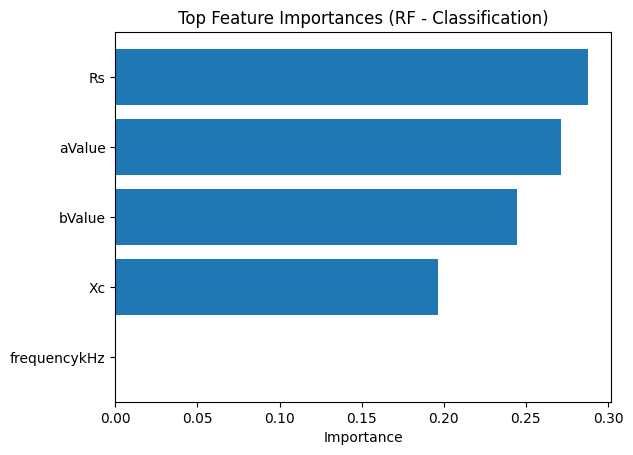

In [ ]:
# Choose a trained model for importance (classification RF)
rf_cls = cls_models['RandomForest']
rf_cls.fit(Xc_train, yc_train)

imp = rf_cls.feature_importances_
feat = Xc.columns
top_idx = np.argsort(imp)[::-1][:15]
top = pd.DataFrame({'feature': feat[top_idx], 'importance': imp[top_idx]})
display(top)

plt.figure()
plt.barh(top['feature'][::-1], top['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top Feature Importances (RF - Classification)')
plt.show()


#FOR SVM

SVM doesn’t have built-in feature importance. This cell uses permutation importance: it randomly shuffles one feature at a time and checks how much accuracy drops.

,feature,importance
0,Rs,0.087533
1,bValue,0.073467
2,aValue,0.070467
3,Xc,0.062533
4,frequencykHz,0.000000


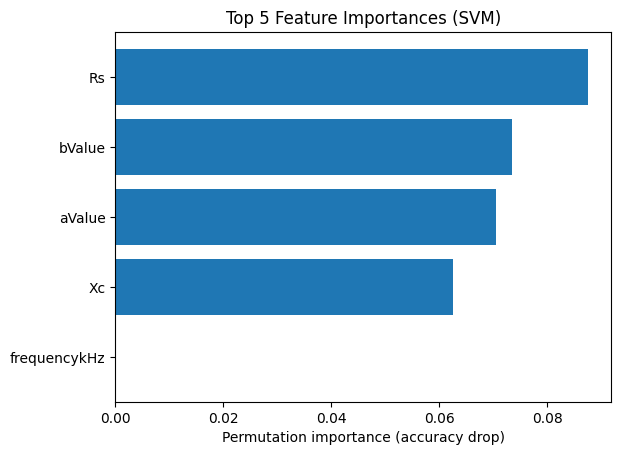

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

svm_model = cls_models['SVM']
svm_model.fit(Xc_train, yc_train)

perm = permutation_importance(
    svm_model, Xc_test, yc_test,
    n_repeats=10, random_state=100, scoring="accuracy"
)

imp = pd.Series(perm.importances_mean, index=Xc.columns).sort_values(ascending=False)
top = imp.head(5).reset_index()
top.columns = ["feature", "importance"]

display(top)

plt.figure()
plt.barh(top["feature"][::-1], top["importance"][::-1])
plt.xlabel("Permutation importance (accuracy drop)")
plt.title("Top 5 Feature Importances (SVM)")
plt.show()


#FOR KNN

Same logic as SVM: shuffle each feature and see which ones reduce accuracy.

,feature,importance
0,aValue,0.101067
1,Rs,0.092467
2,Xc,0.066067
3,bValue,0.065333
4,frequencykHz,0.000000


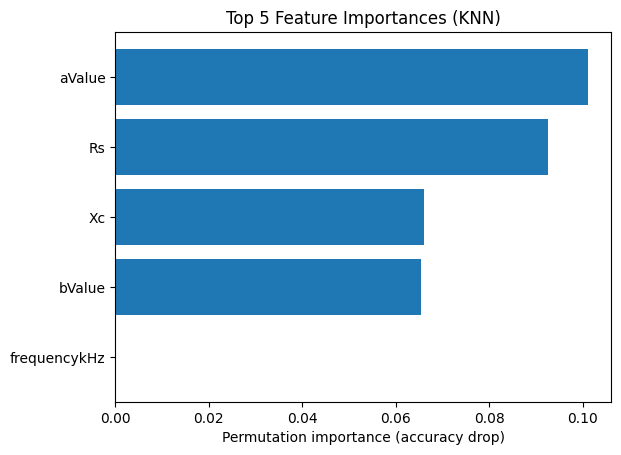

In [ ]:
knn_model = cls_models['KNN']
knn_model.fit(Xc_train, yc_train)

perm = permutation_importance(
    knn_model, Xc_test, yc_test,
    n_repeats=10, random_state=100, scoring="accuracy"
)

imp = pd.Series(perm.importances_mean, index=Xc.columns).sort_values(ascending=False)
top = imp.head(15).reset_index()
top.columns = ["feature", "importance"]

display(top)

plt.figure()
plt.barh(top["feature"][::-1], top["importance"][::-1])
plt.xlabel("Permutation importance (accuracy drop)")
plt.title("Top 5 Feature Importances (KNN)")
plt.show()


#FOR BPNN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# ---- Train BPNN model ----
bpnn_model = cls_models['BPNN']
bpnn_model.fit(Xc_train, yc_train)

# ---- Repeat permutation importance with different seeds ----
seeds = [42, 100, 202]
all_importances = []

for seed in seeds:
    result = permutation_importance(
        bpnn_model,
        Xc_test, yc_test,
        n_repeats=10,
        random_state=seed,
        scoring="accuracy"
    )
    all_importances.append(result.importances_mean)

# Convert to DataFrame
imp_df = pd.DataFrame(
    np.vstack(all_importances),
    columns=Xc.columns
)

# Compute mean and std (stability)
imp_summary = pd.DataFrame({
    "feature": Xc.columns,
    "mean_importance": imp_df.mean(),
    "std_importance": imp_df.std()
}).sort_values("mean_importance", ascending=False)

# Top 15 features
top = imp_summary.head(15)
display(top)


,feature,mean_importance,std_importance
Rs,Rs,0.130067,0.001737
aValue,aValue,0.104867,0.002183
Xc,Xc,0.071578,0.002006
bValue,bValue,0.070867,0.003152
frequencykHz,frequencykHz,0.000000,0.000000


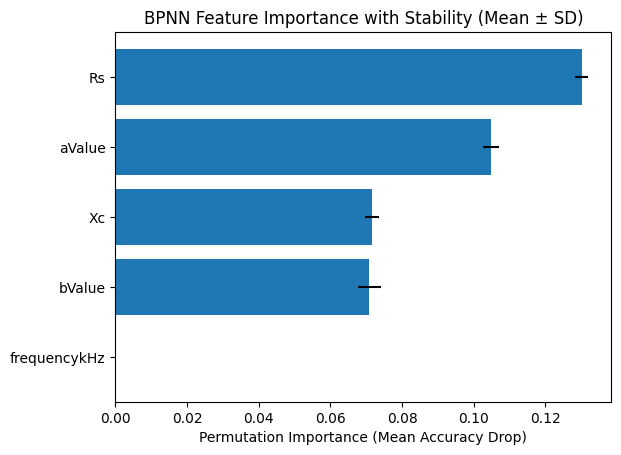

In [ ]:
plt.figure()
plt.barh(
    top["feature"][::-1],
    top["mean_importance"][::-1],
    xerr=top["std_importance"][::-1]
)
plt.xlabel("Permutation Importance (Mean Accuracy Drop)")
plt.title("BPNN Feature Importance with Stability (Mean ± SD)")
plt.show()


SHAP explains model predictions by estimating how each feature contributes. This code uses TreeExplainer which is appropriate for Random Forest.

SHAP computed. Showing summary plot...


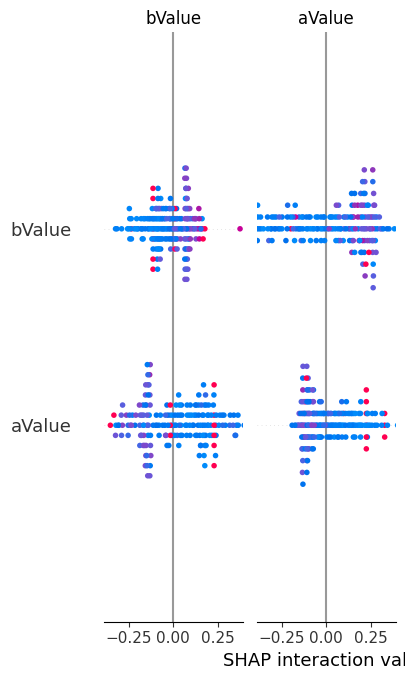

In [ ]:
# SHAP (optional) — will run only if shap is installed
try:
    import shap
    shap.initjs()
    explainer = shap.TreeExplainer(rf_cls)
    # Use a small sample for speed
    X_sample = Xc_test.sample(n=min(200, len(Xc_test)), random_state=42)
    shap_values = explainer.shap_values(X_sample)
    print('SHAP computed. Showing summary plot...')
    shap.summary_plot(shap_values, X_sample, show=True)
except Exception as e:
    print('SHAP not available or failed to run:', e)
    print('Tip: You can still use RF feature_importances_ and permutation importance above.')


## Generate Predictions for the Unlabeled File

This creates `submission.csv` with:
- `Pred_Condition`
- `Pred_Goat_Weight_kg`
- `Pred_Meat_Yield_pct`


This cell loads hackathon_prediction_features.csv, aligns columns to match training features, trains final models on full training data, predicts:

Pred_Condition

Pred_Goat_Weight_kg

Pred_Meat_Yield_pct
and saves submission.csv.

In [ ]:
df_pred = pd.read_csv('hackathon_prediction_features.csv')
df_pred_enc = pd.get_dummies(df_pred, drop_first=True)

# Align columns to training features
df_pred_cls = df_pred_enc.reindex(columns=Xc.columns, fill_value=0)
df_pred_reg = df_pred_enc.reindex(columns=Xr.columns, fill_value=0)

# Train final models on full data (simple strong choices)
final_cls = cls_models['RandomForest']
final_cls.fit(Xc, yc)

final_reg = RandomForestRegressor(n_estimators=500, random_state=42)
final_reg.fit(Xr, yr)

pred_condition = final_cls.predict(df_pred_cls)
pred_targets = final_reg.predict(df_pred_reg)

submission = df_pred.copy()
submission['Pred_Condition'] = pred_condition
submission['Pred_Goat_Weight_kg'] = pred_targets[:,0]
submission['Pred_Meat_Yield_pct'] = pred_targets[:,1]

submission.to_csv('submission.csv', index=False)
print('Saved: submission.csv')


Saved: submission.csv


This cell summarizes model outputs:
1. preview table of predictions
2. descriptive stats for weight/yield
3. class counts
4. histograms for distributions
5. boxplots comparing predicted outcomes by predicted class

Saved: submission.csv

Preview of predictions:


,aValue,bValue,Rs,Xc,Species,Type,frequencykHz,Pred_Condition,Pred_Goat_Weight_kg,Pred_Meat_Yield_pct
0,154.825403,37.397241,168.453166,35.826568,Goat,Carcass,50,P,31.5898,49.6008
1,156.424552,36.261472,153.465749,37.171966,Goat,Carcass,50,P,29.7904,49.9686
2,150.456038,25.634242,138.138783,23.631962,Goat,Carcass,50,H,31.0022,51.9374
3,180.212795,33.418913,177.298053,39.076600,Goat,Carcass,50,P,33.7282,49.1470
4,133.142239,31.698684,151.076585,27.855793,Goat,Carcass,50,P,29.7510,49.4526
5,158.815435,36.418867,157.978048,39.633152,Goat,Carcass,50,P,29.5816,49.4500
6,136.956668,33.712021,138.654613,37.299809,Goat,Carcass,50,H,29.2514,48.1290
7,205.929207,39.773077,199.317240,38.094535,Goat,Carcass,50,P,32.1240,49.1736
8,162.842271,30.082596,154.994467,28.625242,Goat,Carcass,50,P,28.3134,49.5894
9,176.739845,27.895083,179.514560,29.697949,Goat,Carcass,50,H,27.6808,50.8948



Prediction summary (numeric outputs):


,Pred_Goat_Weight_kg,Pred_Meat_Yield_pct
count,1000.000000,1000.000000
mean,32.132733,49.675570
std,7.485893,1.886009
min,25.781600,45.578400
25%,29.447250,48.933400
50%,30.996000,49.443300
75%,32.492500,49.990250
max,84.535400,59.989000



Predicted Condition counts:


,count
Pred_Condition,
P,573
H,427


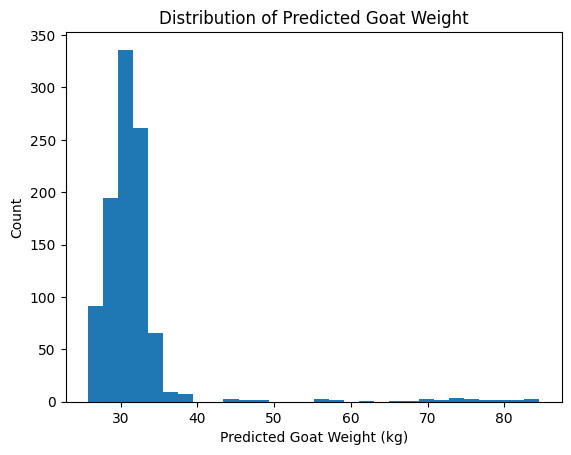

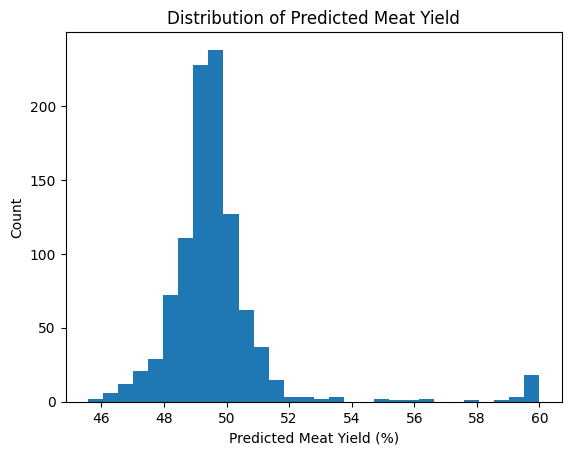

/tmp/ipython-input-2828005123.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_H, data_P], labels=['H','P'])


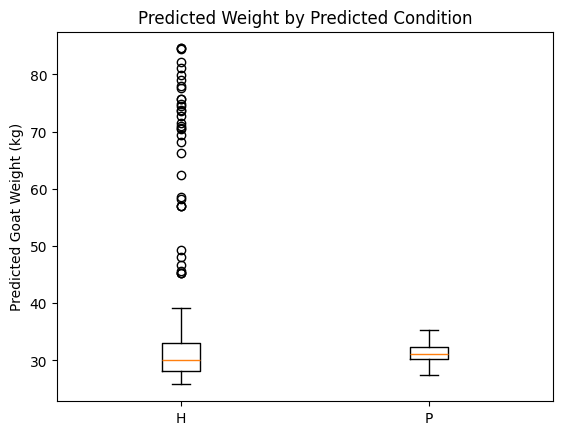

/tmp/ipython-input-2828005123.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_H, data_P], labels=['H','P'])


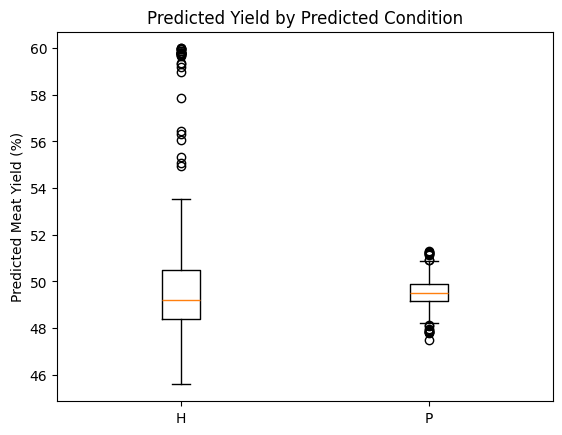

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

# ----------------------------
# Predict on unlabeled file
# ----------------------------
df_pred = pd.read_csv('hackathon_prediction_features.csv')
df_pred_enc = pd.get_dummies(df_pred, drop_first=True)

# Align columns to training features
df_pred_cls = df_pred_enc.reindex(columns=Xc.columns, fill_value=0)
df_pred_reg = df_pred_enc.reindex(columns=Xr.columns, fill_value=0)

# Train final models on full data (simple strong choices)
final_cls = cls_models['RandomForest']
final_cls.fit(Xc, yc)

final_reg = RandomForestRegressor(n_estimators=500, random_state=42)
final_reg.fit(Xr, yr)

# Predictions
pred_condition = final_cls.predict(df_pred_cls)
pred_targets = final_reg.predict(df_pred_reg)

# Build submission
submission = df_pred.copy()
submission['Pred_Condition'] = pred_condition
submission['Pred_Goat_Weight_kg'] = pred_targets[:, 0]
submission['Pred_Meat_Yield_pct'] = pred_targets[:, 1]

# Save
submission.to_csv('submission.csv', index=False)
print('Saved: submission.csv')

# ----------------------------
# Visualize + summarize
# ----------------------------
print("\nPreview of predictions:")
display(submission.head(10))

print("\nPrediction summary (numeric outputs):")
display(submission[['Pred_Goat_Weight_kg','Pred_Meat_Yield_pct']].describe())

print("\nPredicted Condition counts:")
display(submission['Pred_Condition'].value_counts())

# Histograms for regression outputs
plt.figure()
plt.hist(submission['Pred_Goat_Weight_kg'].dropna(), bins=30)
plt.xlabel('Predicted Goat Weight (kg)')
plt.ylabel('Count')
plt.title('Distribution of Predicted Goat Weight')
plt.show()

plt.figure()
plt.hist(submission['Pred_Meat_Yield_pct'].dropna(), bins=30)
plt.xlabel('Predicted Meat Yield (%)')
plt.ylabel('Count')
plt.title('Distribution of Predicted Meat Yield')
plt.show()

# Boxplot by predicted condition (quick interpretation)
if 'Pred_Condition' in submission.columns:
    plt.figure()
    data_H = submission.loc[submission['Pred_Condition'].astype(str).str.upper()=='H', 'Pred_Goat_Weight_kg'].dropna()
    data_P = submission.loc[submission['Pred_Condition'].astype(str).str.upper()=='P', 'Pred_Goat_Weight_kg'].dropna()
    plt.boxplot([data_H, data_P], labels=['H','P'])
    plt.ylabel('Predicted Goat Weight (kg)')
    plt.title('Predicted Weight by Predicted Condition')
    plt.show()

    plt.figure()
    data_H = submission.loc[submission['Pred_Condition'].astype(str).str.upper()=='H', 'Pred_Meat_Yield_pct'].dropna()
    data_P = submission.loc[submission['Pred_Condition'].astype(str).str.upper()=='P', 'Pred_Meat_Yield_pct'].dropna()
    plt.boxplot([data_H, data_P], labels=['H','P'])
    plt.ylabel('Predicted Meat Yield (%)')
    plt.title('Predicted Yield by Predicted Condition')
    plt.show()


Ranks important features for the final RF classifier and RF regressor

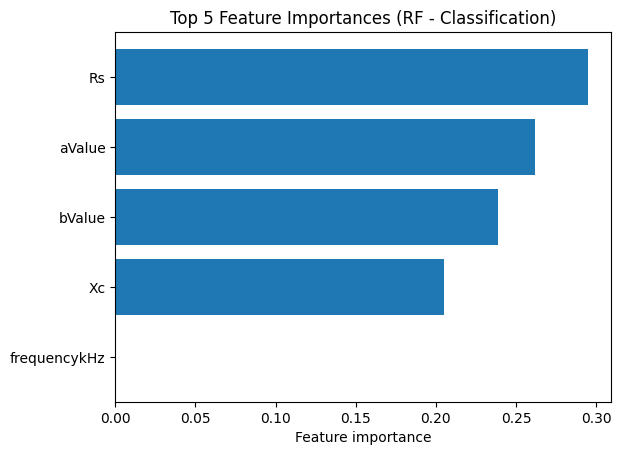

,importance
Rs,0.294712
aValue,0.261661
bValue,0.238475
Xc,0.205153
frequencykHz,0.000000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Classification feature importance ---
rf_cls = final_cls  # already trained
imp_cls = pd.Series(rf_cls.feature_importances_, index=Xc.columns).sort_values(ascending=False)

top_n = 5
top_cls = imp_cls.head(top_n)

plt.figure()
plt.barh(top_cls.index[::-1], top_cls.values[::-1])
plt.xlabel("Feature importance")
plt.title(f"Top {top_n} Feature Importances (RF - Classification)")
plt.show()

display(top_cls.to_frame("importance"))


This sorts predicted results by Pred_Meat_Yield_pct and prints the top 10, plus summary stats.

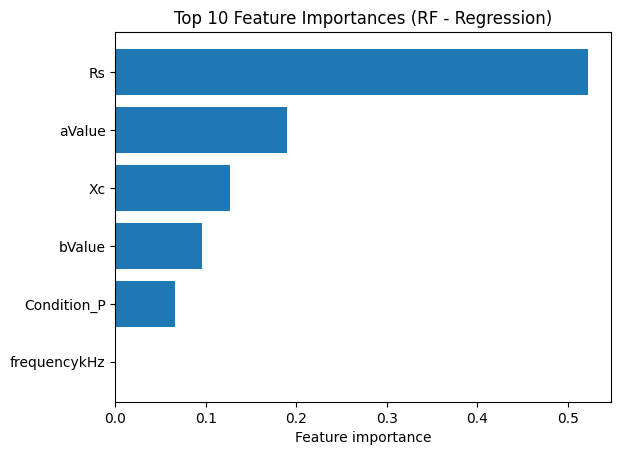

,importance
Rs,0.522252
aValue,0.189603
Xc,0.126652
bValue,0.095754
Condition_P,0.065739
frequencykHz,0.000000


In [ ]:
# --- Regression feature importance ---
rf_reg = final_reg  # already trained
imp_reg = pd.Series(rf_reg.feature_importances_, index=Xr.columns).sort_values(ascending=False)

top_n = 10
top_reg = imp_reg.head(top_n)

plt.figure()
plt.barh(top_reg.index[::-1], top_reg.values[::-1])
plt.xlabel("Feature importance")
plt.title(f"Top {top_n} Feature Importances (RF - Regression)")
plt.show()

display(top_reg.to_frame("importance"))


This creates a side-by-side table on the test sets and calculates:
1. weight error (pred − actual)
2. yield error (pred − actual)

In [ ]:
# Top 10 predicted meat yield samples
top10 = submission.sort_values("Pred_Meat_Yield_pct", ascending=False).head(10)

cols_to_show = [c for c in submission.columns if c in [
    "Pred_Condition", "Pred_Goat_Weight_kg", "Pred_Meat_Yield_pct",
    "aValue", "bValue", "frequencykHz", "Rs", "Xc", "Species", "Type"
]]

display(top10[cols_to_show])

print("\nTop 10 summary:")
print("Avg predicted weight (kg):", round(top10["Pred_Goat_Weight_kg"].mean(), 2))
print("Avg predicted yield (%):", round(top10["Pred_Meat_Yield_pct"].mean(), 2))
print("Predicted condition counts:\n", top10["Pred_Condition"].value_counts())


,aValue,bValue,Rs,Xc,Species,Type,frequencykHz,Pred_Condition,Pred_Goat_Weight_kg,Pred_Meat_Yield_pct
154,1593.000866,292.207662,1599.491514,293.001015,Goat,Carcass,50,H,84.5354,59.9890
165,1593.000866,292.207662,1599.491514,293.001015,Goat,Carcass,50,H,84.5354,59.9890
60,1605.977827,295.258039,1590.246314,296.347119,Goat,Carcass,50,H,79.0486,59.9636
638,1589.104000,292.069220,1588.622391,292.252374,Goat,Carcass,50,H,81.1398,59.9500
810,1578.746471,292.676731,1598.638446,294.031055,Goat,Carcass,50,H,82.2340,59.9496
597,1482.698019,329.342040,1459.897930,332.784695,Goat,Carcass,50,H,73.7696,59.8964
974,1354.551259,302.219683,1375.334108,306.221182,Goat,Carcass,50,H,71.0490,59.8688
309,1364.882846,301.803158,1358.101378,301.921498,Goat,Carcass,50,H,66.2520,59.8164
427,1469.084836,333.127171,1472.896090,334.521160,Goat,Carcass,50,H,69.4490,59.8032
132,1369.772232,302.969757,1381.003606,304.164749,Goat,Carcass,50,H,71.5508,59.8022



Top 10 summary:
Avg predicted weight (kg): 76.36
Avg predicted yield (%): 59.9
Predicted condition counts:
 Pred_Condition
H    10
Name: count, dtype: int64


In [ ]:
# --- Classification predictions ---
y_pred_cls = final_cls.predict(Xc_test)

# --- Regression predictions ---
y_pred_reg = final_reg.predict(Xr_test)

y_pred_reg = pd.DataFrame(
    y_pred_reg,
    columns=["Pred_Goat_Weight_kg", "Pred_Meat_Yield_pct"],
    index=Xr_test.index
)


In [ ]:
# Create combined comparison table
comparison_table = pd.DataFrame({
    "Actual_Condition": yc_test.values,
    "Pred_Condition": y_pred_cls,

    "Actual_Goat_Weight_kg": yr_test["Goat_Weight_kg"].values,
    "Pred_Goat_Weight_kg": y_pred_reg["Pred_Goat_Weight_kg"].values,

    "Actual_Meat_Yield_pct": yr_test["Meat_Yield_pct"].values,
    "Pred_Meat_Yield_pct": y_pred_reg["Pred_Meat_Yield_pct"].values
})

display(comparison_table.head(15))


,Actual_Condition,Pred_Condition,Actual_Goat_Weight_kg,Pred_Goat_Weight_kg,Actual_Meat_Yield_pct,Pred_Meat_Yield_pct
0,H,H,25.0,27.0050,49.5,49.3966
1,H,H,30.6,30.9418,44.9,44.6734
2,H,H,36.0,34.5720,44.4,44.2362
3,H,H,37.8,34.3032,44.2,45.8732
4,P,P,34.4,33.0832,46.9,46.0324
5,H,H,28.9,29.9350,51.9,50.9828
6,H,H,25.0,26.7816,43.6,43.6724
7,H,H,42.1,38.6344,48.5,47.5406
8,P,P,26.7,27.8558,40.4,41.5966
9,P,P,33.7,33.1778,44.8,44.8456


In [ ]:
comparison_table["Weight_Error_kg"] = (
    comparison_table["Pred_Goat_Weight_kg"]
    - comparison_table["Actual_Goat_Weight_kg"]
)

comparison_table["Yield_Error_pct"] = (
    comparison_table["Pred_Meat_Yield_pct"]
    - comparison_table["Actual_Meat_Yield_pct"]
)

display(comparison_table.head(15))


,Actual_Condition,Pred_Condition,Actual_Goat_Weight_kg,Pred_Goat_Weight_kg,Actual_Meat_Yield_pct,Pred_Meat_Yield_pct,Weight_Error_kg,Yield_Error_pct
0,H,H,25.0,27.0050,49.5,49.3966,2.0050,-0.1034
1,H,H,30.6,30.9418,44.9,44.6734,0.3418,-0.2266
2,H,H,36.0,34.5720,44.4,44.2362,-1.4280,-0.1638
3,H,H,37.8,34.3032,44.2,45.8732,-3.4968,1.6732
4,P,P,34.4,33.0832,46.9,46.0324,-1.3168,-0.8676
5,H,H,28.9,29.9350,51.9,50.9828,1.0350,-0.9172
6,H,H,25.0,26.7816,43.6,43.6724,1.7816,0.0724
7,H,H,42.1,38.6344,48.5,47.5406,-3.4656,-0.9594
8,P,P,26.7,27.8558,40.4,41.5966,1.1558,1.1966
9,P,P,33.7,33.1778,44.8,44.8456,-0.5222,0.0456


In [ ]:
import numpy as np
import pandas as pd

# Thresholds (adjust if you want)
WEIGHT_GOOD = 3.0      # kg
WEIGHT_BAD  = 8.0      # kg
YIELD_GOOD  = 2.0      # %
YIELD_BAD   = 5.0      # %

def highlight_error(val, good, bad):
    """Green for small error, red for large error"""
    if abs(val) <= good:
        return "background-color: #c6efce"   # light green
    elif abs(val) >= bad:
        return "background-color: #ffc7ce"   # light red
    else:
        return "background-color: #ffeb9c"   # yellow (moderate)

def style_table(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)

    # Highlight condition correctness
    styles.loc[
        df["Actual_Condition"] == df["Pred_Condition"],
        "Pred_Condition"
    ] = "background-color: #c6efce"

    styles.loc[
        df["Actual_Condition"] != df["Pred_Condition"],
        "Pred_Condition"
    ] = "background-color: #ffc7ce"

    # Highlight numeric errors
    styles["Weight_Error_kg"] = df["Weight_Error_kg"].apply(
        lambda x: highlight_error(x, WEIGHT_GOOD, WEIGHT_BAD)
    )

    styles["Yield_Error_pct"] = df["Yield_Error_pct"].apply(
        lambda x: highlight_error(x, YIELD_GOOD, YIELD_BAD)
    )

    return styles


In [ ]:
styled_table = comparison_table.style.apply(style_table, axis=None)
styled_table


,Actual_Condition,Pred_Condition,Actual_Goat_Weight_kg,Pred_Goat_Weight_kg,Actual_Meat_Yield_pct,Pred_Meat_Yield_pct,Weight_Error_kg,Yield_Error_pct
0,H,H,25.000000,27.005000,49.500000,49.396600,2.005000,-0.103400
1,H,H,30.600000,30.941800,44.900000,44.673400,0.341800,-0.226600
2,H,H,36.000000,34.572000,44.400000,44.236200,-1.428000,-0.163800
3,H,H,37.800000,34.303200,44.200000,45.873200,-3.496800,1.673200
4,P,P,34.400000,33.083200,46.900000,46.032400,-1.316800,-0.867600
5,H,H,28.900000,29.935000,51.900000,50.982800,1.035000,-0.917200
6,H,H,25.000000,26.781600,43.600000,43.672400,1.781600,0.072400
7,H,H,42.100000,38.634400,48.500000,47.540600,-3.465600,-0.959400
8,P,P,26.700000,27.855800,40.400000,41.596600,1.155800,1.196600
9,P,P,33.700000,33.177800,44.800000,44.845600,-0.522200,0.045600


#PER CLASS ACCURACY

In [ ]:
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(
    comparison_table["Actual_Condition"],
    comparison_table["Pred_Condition"]
)

print("Overall Accuracy:", round(overall_acc, 3))

# Per-class accuracy
per_class_acc = (
    comparison_table
    .assign(correct = comparison_table["Actual_Condition"] == comparison_table["Pred_Condition"])
    .groupby("Actual_Condition")["correct"]
    .mean()
)

print("\nPer-class Accuracy:")
display(per_class_acc.to_frame("Accuracy"))


Overall Accuracy: 1.0

Per-class Accuracy:


,Accuracy
Actual_Condition,
H,1.0
P,1.0


#MSE error for Regression

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_weight = mean_absolute_error(
    comparison_table["Actual_Goat_Weight_kg"],
    comparison_table["Pred_Goat_Weight_kg"]
)

mae_yield = mean_absolute_error(
    comparison_table["Actual_Meat_Yield_pct"],
    comparison_table["Pred_Meat_Yield_pct"]
)

print("MAE – Goat Weight (kg):", round(mae_weight, 3))
print("MAE – Meat Yield (%):", round(mae_yield, 3))


MAE – Goat Weight (kg): 1.367
MAE – Meat Yield (%): 0.598


In [ ]:
summary = pd.DataFrame({
    "Metric": [
        "Overall Accuracy",
        "Accuracy (Class H)",
        "Accuracy (Class P)",
        "MAE Weight (kg)",
        "MAE Meat Yield (%)"
    ],
    "Value": [
        overall_acc,
        per_class_acc.get("H", np.nan),
        per_class_acc.get("P", np.nan),
        mae_weight,
        mae_yield
    ]
})

display(summary.round(3))


,Metric,Value
0,Overall Accuracy,1.000
1,Accuracy (Class H),1.000
2,Accuracy (Class P),1.000
3,MAE Weight (kg),1.367
4,MAE Meat Yield (%),0.598


,Actual_Condition,Pred_Condition,Actual_Goat_Weight_kg,Pred_Goat_Weight_kg,Actual_Meat_Yield_pct,Pred_Meat_Yield_pct,Weight_Error_kg,Yield_Error_pct
0,H,H,25.0,27.0050,49.5,49.3966,2.0050,-0.1034
1,H,H,30.6,30.9418,44.9,44.6734,0.3418,-0.2266
2,H,H,36.0,34.5720,44.4,44.2362,-1.4280,-0.1638
3,H,H,37.8,34.3032,44.2,45.8732,-3.4968,1.6732
4,P,P,34.4,33.0832,46.9,46.0324,-1.3168,-0.8676
5,H,H,28.9,29.9350,51.9,50.9828,1.0350,-0.9172
6,H,H,25.0,26.7816,43.6,43.6724,1.7816,0.0724
7,H,H,42.1,38.6344,48.5,47.5406,-3.4656,-0.9594
8,P,P,26.7,27.8558,40.4,41.5966,1.1558,1.1966
9,P,P,33.7,33.1778,44.8,44.8456,-0.5222,0.0456



=== CLASSIFICATION RESULTS ===
Accuracy: 1.0


<Figure size 640x480 with 0 Axes>

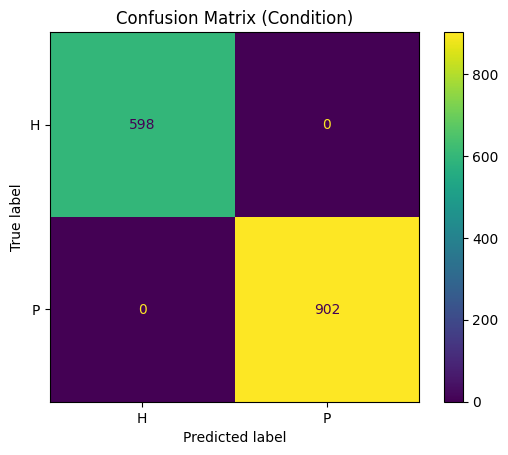


=== REGRESSION RESULTS ===


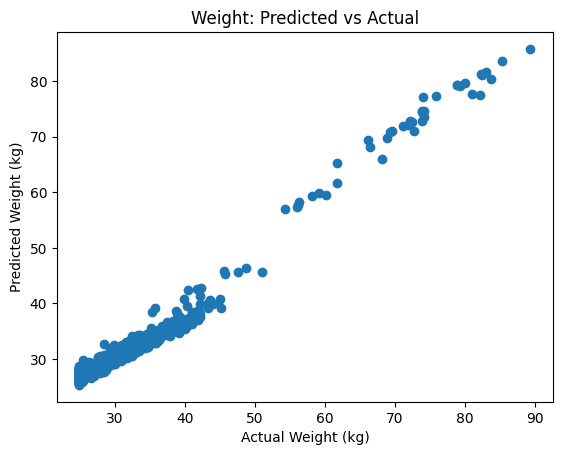

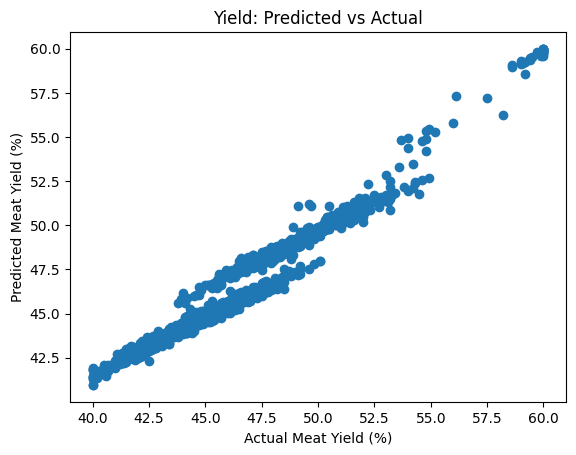

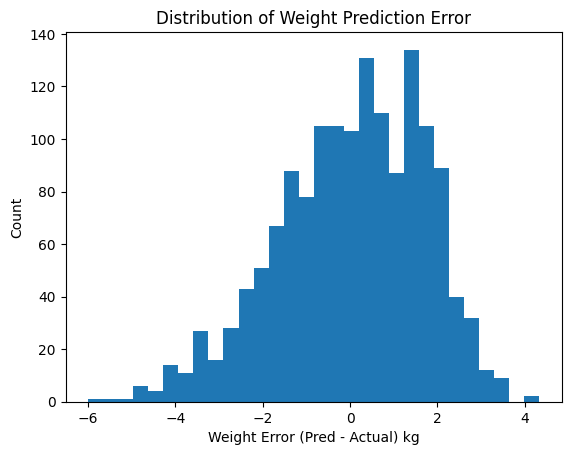

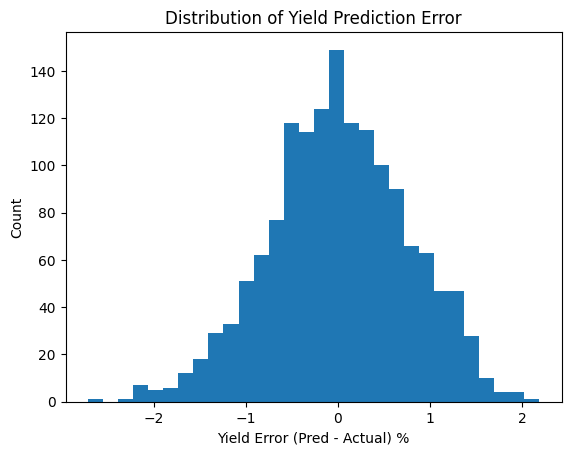

/tmp/ipython-input-389879789.py:95: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_H, data_P], labels=["Pred H", "Pred P"])


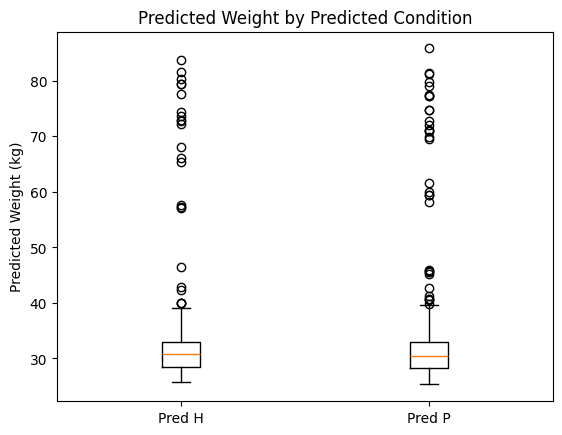

/tmp/ipython-input-389879789.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_H, data_P], labels=["Pred H", "Pred P"])


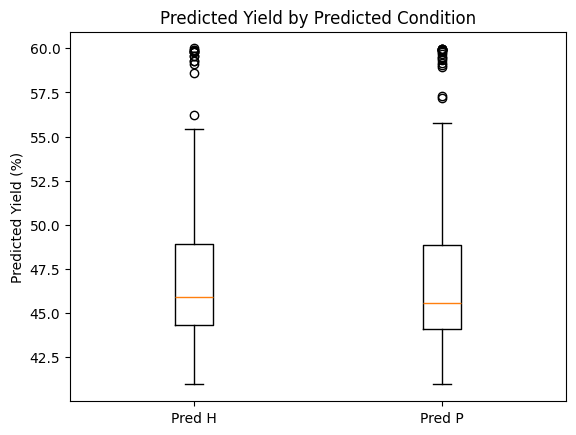


=== FEATURE IMPORTANCE (Classification RF) ===


,importance
Rs,0.294712
aValue,0.261661
bValue,0.238475
Xc,0.205153
frequencykHz,0.000000


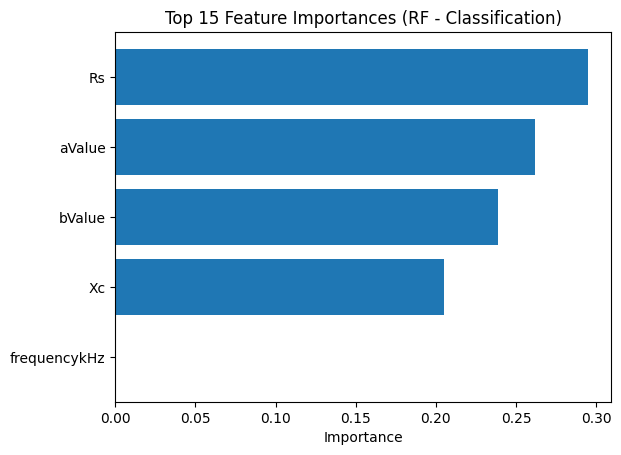


=== PERMUTATION IMPORTANCE (Classification RF) ===


,perm_importance_mean
aValue,0.253933
Rs,0.247867
Xc,0.215800
bValue,0.198667
frequencykHz,0.000000


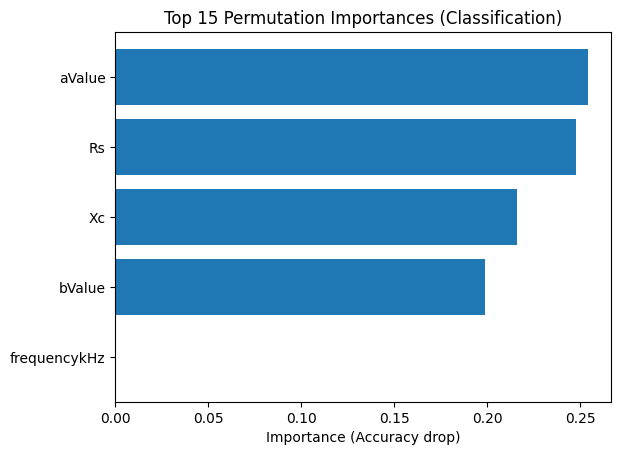


Done All plots generated.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

# ----------------------------
# 1) Generate predictions
# ----------------------------
# Classification predictions
pred_cls = final_cls.predict(Xc_test)

# Regression predictions (multi-output)
pred_reg = final_reg.predict(Xr_test)
pred_reg = pd.DataFrame(pred_reg, columns=["Pred_Goat_Weight_kg", "Pred_Meat_Yield_pct"], index=Xr_test.index)

# Build comparison table (side-by-side)
comparison_table = pd.DataFrame({
    "Actual_Condition": yc_test.values,
    "Pred_Condition": pred_cls,
    "Actual_Goat_Weight_kg": yr_test["Goat_Weight_kg"].values,
    "Pred_Goat_Weight_kg": pred_reg["Pred_Goat_Weight_kg"].values,
    "Actual_Meat_Yield_pct": yr_test["Meat_Yield_pct"].values,
    "Pred_Meat_Yield_pct": pred_reg["Pred_Meat_Yield_pct"].values
})

# Errors
comparison_table["Weight_Error_kg"] = comparison_table["Pred_Goat_Weight_kg"] - comparison_table["Actual_Goat_Weight_kg"]
comparison_table["Yield_Error_pct"] = comparison_table["Pred_Meat_Yield_pct"] - comparison_table["Actual_Meat_Yield_pct"]

display(comparison_table.head(10))

# ----------------------------
# 2) Classification visuals
# ----------------------------
print("\n=== CLASSIFICATION RESULTS ===")
acc = accuracy_score(comparison_table["Actual_Condition"], comparison_table["Pred_Condition"])
print("Accuracy:", round(acc, 4))

labels = sorted(pd.Series(comparison_table["Actual_Condition"]).unique())
cm = confusion_matrix(comparison_table["Actual_Condition"], comparison_table["Pred_Condition"], labels=labels)

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix (Condition)")
plt.show()

# ----------------------------
# 3) Regression visuals: Predicted vs Actual
# ----------------------------
print("\n=== REGRESSION RESULTS ===")

# Weight scatter
plt.figure()
plt.scatter(comparison_table["Actual_Goat_Weight_kg"], comparison_table["Pred_Goat_Weight_kg"])
plt.xlabel("Actual Weight (kg)")
plt.ylabel("Predicted Weight (kg)")
plt.title("Weight: Predicted vs Actual")
plt.show()

# Yield scatter
plt.figure()
plt.scatter(comparison_table["Actual_Meat_Yield_pct"], comparison_table["Pred_Meat_Yield_pct"])
plt.xlabel("Actual Meat Yield (%)")
plt.ylabel("Predicted Meat Yield (%)")
plt.title("Yield: Predicted vs Actual")
plt.show()

# ----------------------------
# 4) Error distribution plots (Residual checks)
# ----------------------------
plt.figure()
plt.hist(comparison_table["Weight_Error_kg"], bins=30)
plt.xlabel("Weight Error (Pred - Actual) kg")
plt.ylabel("Count")
plt.title("Distribution of Weight Prediction Error")
plt.show()

plt.figure()
plt.hist(comparison_table["Yield_Error_pct"], bins=30)
plt.xlabel("Yield Error (Pred - Actual) %")
plt.ylabel("Count")
plt.title("Distribution of Yield Prediction Error")
plt.show()

# ----------------------------
# 5) Boxplots: outputs by predicted condition (decision-style view)
# ----------------------------
plt.figure()
data_H = comparison_table.loc[comparison_table["Pred_Condition"].astype(str).str.upper()=="H", "Pred_Goat_Weight_kg"].dropna()
data_P = comparison_table.loc[comparison_table["Pred_Condition"].astype(str).str.upper()=="P", "Pred_Goat_Weight_kg"].dropna()
plt.boxplot([data_H, data_P], labels=["Pred H", "Pred P"])
plt.ylabel("Predicted Weight (kg)")
plt.title("Predicted Weight by Predicted Condition")
plt.show()

plt.figure()
data_H = comparison_table.loc[comparison_table["Pred_Condition"].astype(str).str.upper()=="H", "Pred_Meat_Yield_pct"].dropna()
data_P = comparison_table.loc[comparison_table["Pred_Condition"].astype(str).str.upper()=="P", "Pred_Meat_Yield_pct"].dropna()
plt.boxplot([data_H, data_P], labels=["Pred H", "Pred P"])
plt.ylabel("Predicted Yield (%)")
plt.title("Predicted Yield by Predicted Condition")
plt.show()

# ----------------------------
# 6) Feature importance (RF built-in) + Permutation importance
# ----------------------------
print("\n=== FEATURE IMPORTANCE (Classification RF) ===")
if hasattr(final_cls, "feature_importances_"):
    imp = pd.Series(final_cls.feature_importances_, index=Xc_test.columns).sort_values(ascending=False).head(15)
    display(imp.to_frame("importance"))

    plt.figure()
    plt.barh(imp.index[::-1], imp.values[::-1])
    plt.xlabel("Importance")
    plt.title("Top 15 Feature Importances (RF - Classification)")
    plt.show()

print("\n=== PERMUTATION IMPORTANCE (Classification RF) ===")
perm = permutation_importance(final_cls, Xc_test, yc_test, n_repeats=10, random_state=42, scoring="accuracy")
perm_s = pd.Series(perm.importances_mean, index=Xc_test.columns).sort_values(ascending=False).head(15)
display(perm_s.to_frame("perm_importance_mean"))

plt.figure()
plt.barh(perm_s.index[::-1], perm_s.values[::-1])
plt.xlabel("Importance (Accuracy drop)")
plt.title("Top 15 Permutation Importances (Classification)")
plt.show()

print("\nDone All plots generated.")
